# 2022/01/11 Make Pipeline

#### Aim
create the audio pipeline

#### imports external modules

In [1]:
import pathlib
import sys
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


#### Get & Add the Path

In [2]:
current_dir: Path = pathlib.Path().cwd().resolve()
project_root: Path = current_dir.parent
data_dir: Path = project_root / "data"

sys.path.append(str(project_root))

#### Get the WAV file

In [3]:
audio_dir: Path = data_dir / "train" / "audio"
audio_file1: Path = audio_dir / "000315.wav"

#### WAV2Logmel2Tensor

spectrogram: torch.Size([8, 128, 1551])


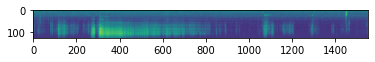

In [4]:
from corsmal_challenge.data.audio import load_wav


spectrogram = load_wav(audio_file1).generate_mel_spectrogram().log2()
print(f"spectrogram: {spectrogram.size()}")
plt.figure()
plt.imshow(spectrogram[0].numpy())
plt.show()

#### Get more files & create input tensor

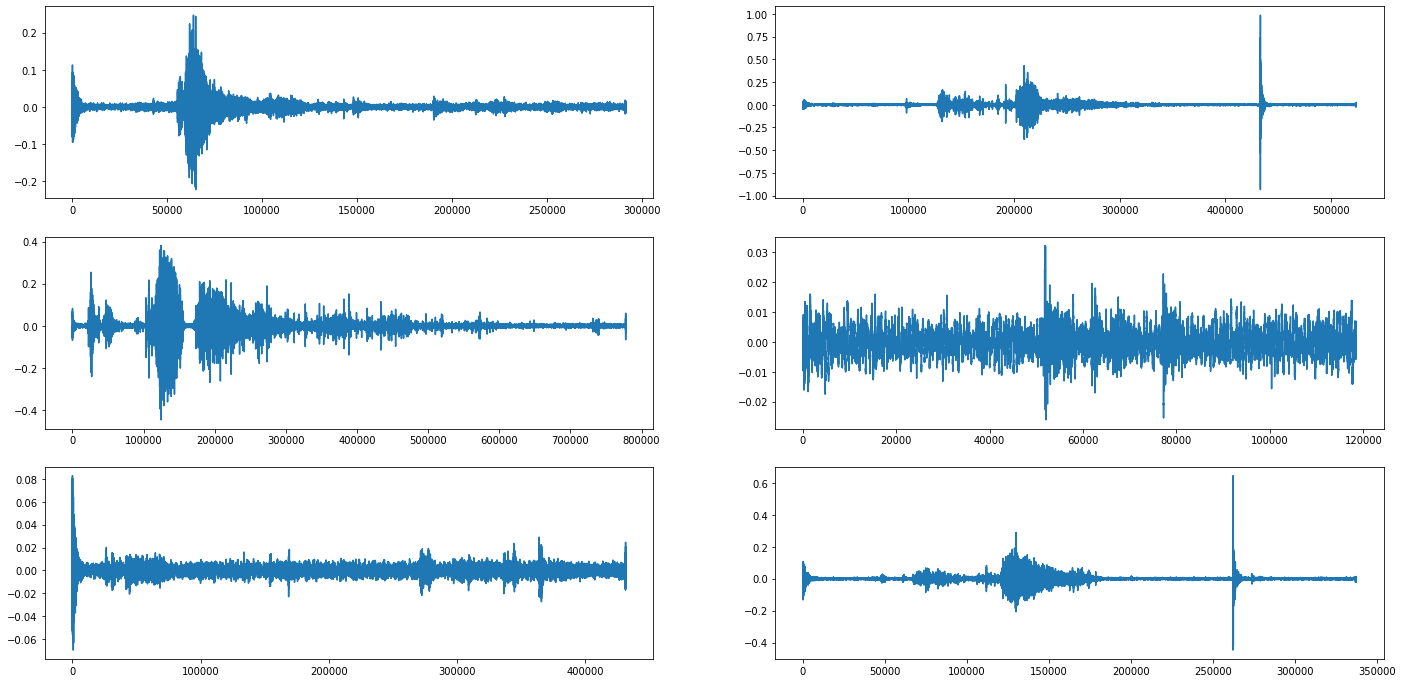

spectrogram: torch.Size([8, 128, 285])
spectrogram: torch.Size([8, 128, 512])
spectrogram: torch.Size([8, 128, 760])
spectrogram: torch.Size([8, 128, 116])
spectrogram: torch.Size([8, 128, 422])
spectrogram: torch.Size([8, 128, 330])


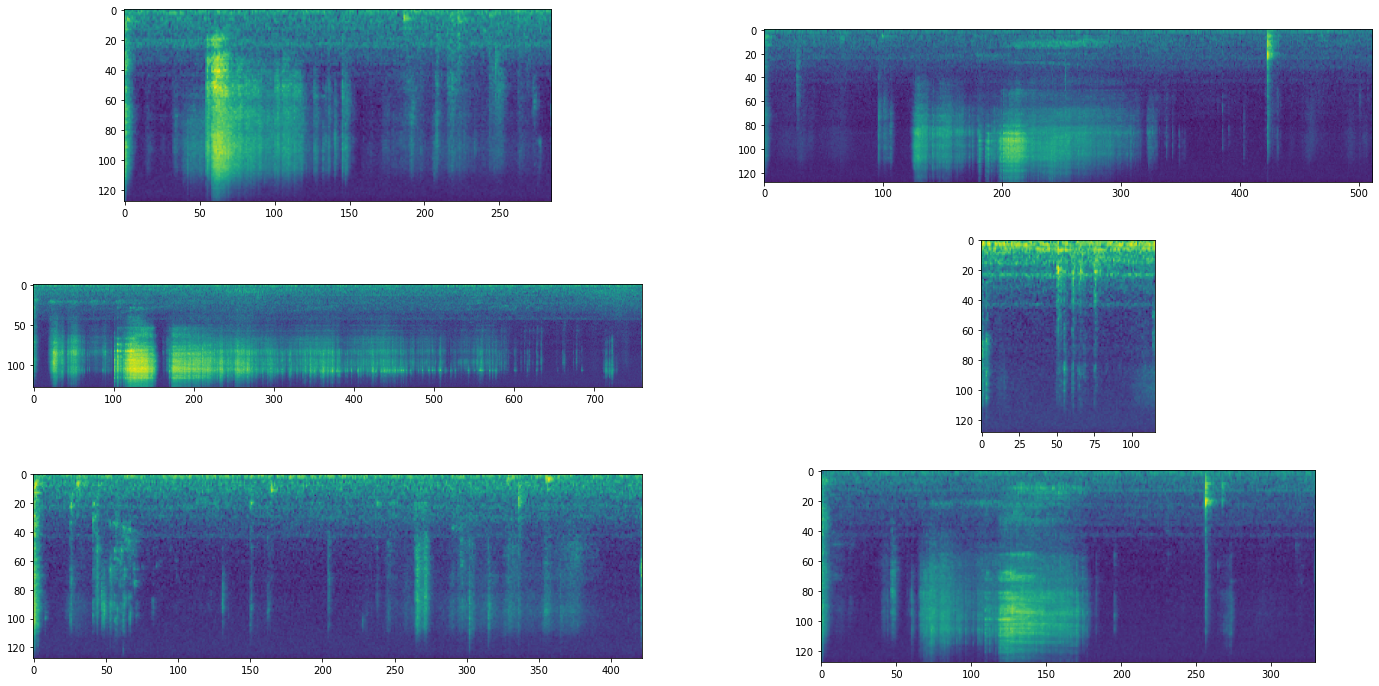

inputs: torch.Size([6, 8, 760, 128])


In [5]:
from corsmal_challenge.data.audio import Wav


filenames: List[Path] = [
    audio_dir / "000000.wav",
    audio_dir / "000010.wav",
    audio_dir / "000020.wav",
    audio_dir / "000001.wav",
    audio_dir / "000011.wav",
    audio_dir / "000021.wav",
]
wavs: List[Wav] = [load_wav(fname) for fname in filenames]

# show raw audio
plt.figure(figsize=[24, 12])
for i, wav in enumerate(wavs):
    plt.subplot(3, 2, i + 1)
    plt.plot(wav.wav_audio_data[0].numpy())
plt.show()

stack: List[torch.Tensor] = []
masks: List[torch.Tensor] = []

# get spectrogram
plt.figure(figsize=[24, 12])
for i, fname in enumerate(filenames):
    spec = load_wav(fname).generate_mel_spectrogram().log2()
    stack.append(spec)
    masks.append(torch.ones(spec.shape[-1]))
    print(f"spectrogram: {spec.size()}")
    plt.subplot(3, 2, i + 1)
    plt.imshow(spec[0].numpy())
plt.show()

# add padding & mask at the tail of the sequence
max_len = max([tensor.shape[-1] for tensor in stack])
for i, tensor in enumerate(stack):
    stack[i] = F.pad(
        tensor,
        (0, max_len - tensor.shape[-1]),
        "constant",
        0,
    )
    masks[i] = torch.ones(max_len)
    masks[i][tensor.shape[-1]:] *= 0

# concat batches and permute
inputs: torch.Tensor = torch.stack(stack, dim=0).permute(0, 1, 3, 2)
print(f"inputs: {inputs.size()}")


In [6]:
from corsmal_challenge.models.audio import LogMelEncoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = LogMelEncoder(in_channels=8, num_encoder_blocks=6, embed_dim=128, num_heads=4, dropout=0)

inputs = inputs.to(device)
encoder = encoder.to(device)

y = encoder(inputs)
print(f"y: {y.size()}")

y: torch.Size([6, 381, 128])
